In [1]:
import os
import io
import json
import csv
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import torch.nn as nn
from torchsummary import summary

In [2]:
# Use MPS (Apple GPU) if available; otherwise, fall back to CPU
#DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

DEVICE = torch.device("cuda")

# Using consolidated training data
1. Legibility
2. Digit classification

Run the following cell to create merged ground truths:

In [71]:
# File paths (update these as needed)
txt_file_path = "./data/SoccerNetLegibility/train/train_gt.txt" #legibility ground truth (frame level)
json_file_path = "./data/train_gt_numbers.json" #numbers ground truth (tracklet level)
output_file_path = "./data/merged_ground_truths.csv"

# Step 1: Load legibility ground truths from TXT file
legibility_data = {}

with open(txt_file_path, "r") as txt_file:
    for line in txt_file:
        parts = line.strip().split(",")
        frame_name = parts[0].strip(".jpg")  # Format: trackletID_frameID.jpg
        legibility = int(parts[1])  # 0 or 1
        legibility_data[frame_name] = legibility

# Step 2: Load jersey number ground truths from JSON file
with open(json_file_path, "r") as json_file:
    jersey_numbers = json.load(json_file)  # Dictionary: {"trackletID": jersey_number}

# Step 3: Merge data and write to output file
with open(output_file_path, "w") as output_file:
    for frame_name, legibility in legibility_data.items():
        tracklet_id = frame_name.split("_")[0]  # Extract tracklet number
        jersey_number = jersey_numbers.get(tracklet_id, -1)  # Default to -1 if not found
        output_file.write(f"{frame_name}, {legibility}, {jersey_number}\n")

print(f"Merged ground truths saved to {output_file_path}")


In [3]:
def compute_image_dimensions(img_dir="./data/imgs"):
    widths = []
    heights = []
    
    # Iterate over files in the directory
    for filename in os.listdir(img_dir):
        if filename.lower().endswith(".jpg"):
            img_path = os.path.join(img_dir, filename)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    if not widths or not heights:
        print("No images processed successfully.")
        return None
    
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    min_width = np.min(widths)
    max_width = np.max(widths)
    min_height = np.min(heights)
    max_height = np.max(heights)
    
    print("Average width:", avg_width)
    print("Average height:", avg_height)
    print("Min width:", min_width)
    print("Max width:", max_width)
    print("Min height:", min_height)
    print("Max height:", max_height)

In [4]:
compute_image_dimensions("./data/SoccerNetLegibility/SoccerNetLegibility/train/images")

Average width: 49.01357229158276
Average height: 104.46041079339508
Min width: 1
Max width: 179
Min height: 2
Max height: 255


In [5]:
# New Preprocessing with Increased Image Size
transform = transforms.Compose([
    transforms.Resize(128),      # Resize the smaller edge to 128 while keeping aspect ratio
    transforms.CenterCrop(128),  # Crop to 128x128 to standardize size
    transforms.ToTensor()        # Convert to tensor
])


In [6]:
def top_crop(img, size):
    return transforms.functional.crop(img, top=0, left=0, height=size, width=size)

# transformations  cropping upper section of the frame instead of center (jersey numbers usually located on upper half of the image)
transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.Lambda(lambda img: top_crop(img, 128)),  # Crop from top instead of center
    transforms.ToTensor()
])


In [76]:
# Loading ground truths
# For each cropped jersey number image (named as <tracklet>_<frame>.jpg), it extracts the <tracklet> part from the name   
# and looks up its ground truth in the JSON file, loads the image, performs transformations, and appends it to a list.

def load_merged_data(transform = transform, img_dir="./data/SoccerNetLegibility/train/images", gt_file="./data/merged_ground_truths.csv"):
    # Load the ground truths into a dictionary
    gt_data = {}

    with open(gt_file, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            frame_id = row[0].strip()  # tracklet_number_frame_id
            legibility = int(row[1].strip())  # 0 or 1
            jersey_number = int(row[2].strip())  # -1 or 1 to 99
            gt_data[frame_id] = (legibility, jersey_number)


    images = []
    labels = []
    
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            # key = filename.split("_")[0]  # Extract tracklet ID from filename
            # label = gt_data[key]

            img_path = os.path.join(img_dir, filename)
            try:
                img = Image.open(img_path).convert("RGB")  
                img_tensor = transform(img)  
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue 
            
            images.append(img_tensor)

            key = filename.split(".")
            label = gt_data[key[0]]

            # we use separate labels for legibility and jersey number (so the model will have to output them separately)
            if label[1] == -1 or label[0] == 0:
                labels.append([0, 0])   
            else:
                labels.append(label)

    
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)  # return Tensors


In [7]:
# Load images and labels from merged_ground_truths.csv file for single-loss
def load_data_csv(transform = transform, img_dir="./data/SoccerNetLegibility/SoccerNetLegibility//train/images", gt_file="./data/merged_ground_truths.csv"):
    # Load the ground truths into a dictionary
    gt_data = {}

    with open(gt_file, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            frame_id = row[0].strip()  # tracklet_number_frame_id
            jersey_number = int(row[2].strip())  # -1 or 1 to 99
            gt_data[frame_id] = jersey_number


    images = []
    labels = []
    
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            # key = filename.split("_")[0]  # Extract tracklet ID from filename
            # label = gt_data[key]

            img_path = os.path.join(img_dir, filename)
            try:
                img = Image.open(img_path).convert("RGB")  
                img_tensor = transform(img)  
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue 
            
            images.append(img_tensor)

            key = filename.split(".")
            label = gt_data[key[0]]

            if label == -1:
                labels.append(0)   
            else:
                labels.append(label)

    
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)  # return Tensors

In [8]:
# Load images and labels in the format: <legibility>, <jersey number>
# images, labels = load_merged_data()

# Load images just using the number as the ground truth:
images, labels = load_data_csv(transform_test)

In [9]:
dataset = TensorDataset(images, labels)

# 95-5 train-test split
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# For initial model testing, try to overfit to a small subset of the training data to see if the model has sufficient complexity
small_train_size = int(0.15 * len(train_dataset))
small_indices = random.sample(range(len(train_dataset)), small_train_size)
small_train_dataset = torch.utils.data.Subset(train_dataset, small_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Small test dataset size: {len(small_train_dataset)}")

Total dataset size: 24830
Train dataset size: 23588
Test dataset size: 1242
Small test dataset size: 3538


# Visualizing the dataset

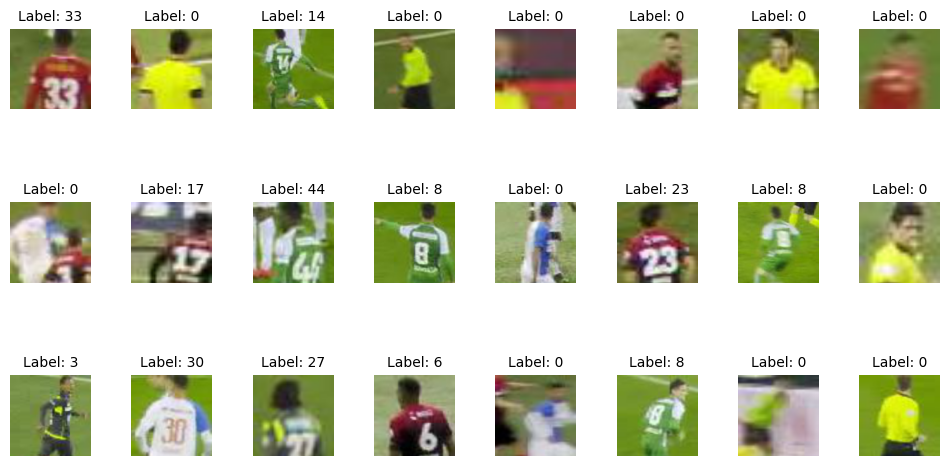

In [10]:
image_batch, label_batch = next(iter(train_loader))  # Get the next batch from the train loader

num_cols = 8
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes to make it easier to index them
axes = axes.flatten()

for i in range(num_rows * num_cols):
    ax = axes[i]
    image = image_batch[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    # image = image * 1 + 0  
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label_batch[i].item()}', fontsize=10)
    ax.axis('off')  # Turn off the axes for each subplot

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [11]:
def plot_label_histogram(labels, title="", multi_label=False):

    if multi_label:
        # Convert the tens and ones digits back to the original labels
        labels_as_int = [tens * 10 + ones if tens != 10 and ones != 10 else 0 for tens, ones in labels]
    else:
        labels_as_int = [int(label) for label in labels]
    
    # Set up the bins so that each integer gets its own bar
    bins = np.arange(0, 100 + 2)  # +2 so that the upper value is included
    plt.figure(figsize=(13, 8))
    plt.hist(labels_as_int, bins=bins, edgecolor='black', align='left')
    plt.xlabel("Ground Truth Number")
    plt.ylabel("Frequency")
    if title:
        plt.title(title)
    else:
        plt.title(f"Histogram of Ground Truth Numbers (0-99)")
    plt.xticks(np.arange(0, 100 + 1, step=2))  
    plt.show()

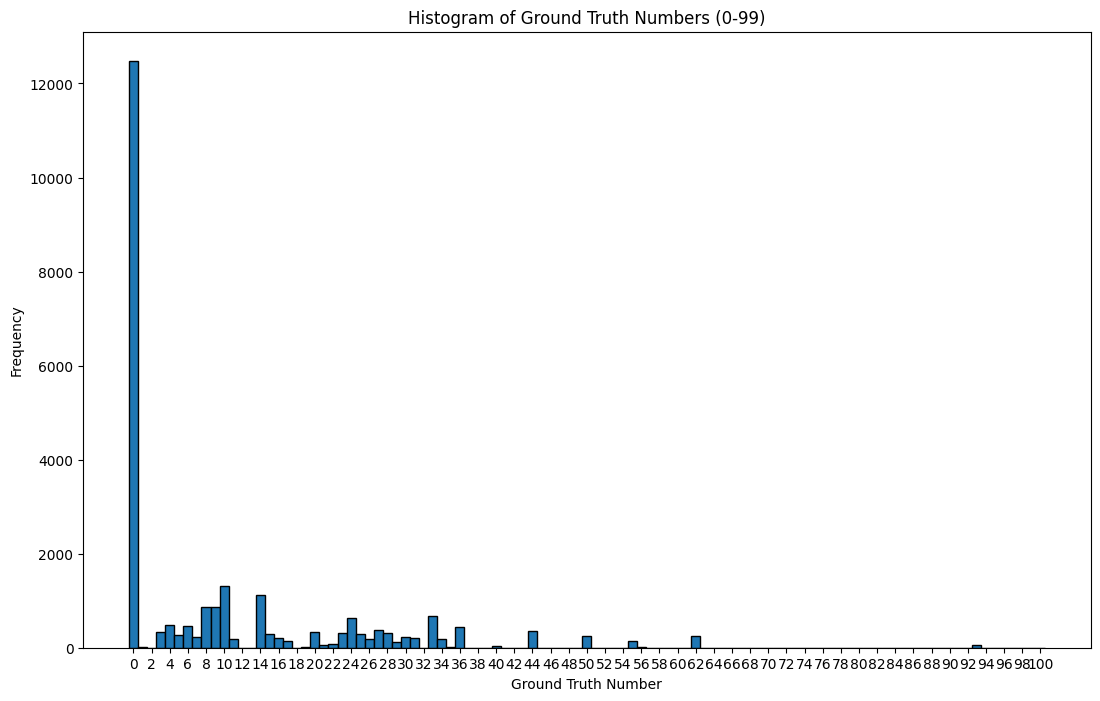

In [12]:
plot_label_histogram(labels)

# Training the model

In [13]:
class JerseyNumberClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberClassifier, self).__init__()
        
        # 128x128 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 64x64 input
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 input
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 input
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 input
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 4x4 input
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 2x2 output instead of 1x1
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 8192),  # Adjusted from 1024 * 1 * 1
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.fc(x)
        return x


In [14]:
net = JerseyNumberClassifier()
#summary(net, (3,128,128))

In [15]:
def training_loop(model, optimizer, criterion, epochs, train_loader, device ):
    total_train_losses = []
    total_train_acc = []

    for epoch in range(epochs):

        total_loss_in_epoch = 0
        correct_preds = 0
        total_preds = 0

        # Training 
        for inputs, ground_truths in train_loader:

            inputs = inputs.to(device)
            ground_truths = ground_truths.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)    
            loss = criterion(outputs, ground_truths)     
            loss.backward()
            optimizer.step()

            total_loss_in_epoch += loss.item()       # accumulate loss for this batch
            correct_preds += (torch.argmax(outputs, dim=1) == ground_truths).sum().item()
            total_preds += outputs.size(0)

        # average out the loss and accuracy across the batch
        avg_train_loss = round(total_loss_in_epoch / inputs.size(0), 4)
        train_accuracy = round((correct_preds / total_preds) * 100, 4)

        total_train_losses.append(avg_train_loss)
        total_train_acc.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss} | Train Accuracy: {train_accuracy}% \nNumber of jersey numbers correctly predicted: {correct_preds}")
        print("=" * 20)


In [16]:
def evaluate_model (model, test_loader, device):
  model.eval()

  correct = 0
  total = 0

  #disable gradient computation
  with torch.no_grad():
    # iterate over test batches
    for inputs, labels in test_loader:
      # moving inputs and labels to gpu
      inputs, labels = inputs.to(device), labels.to(device)

      #forward pass
      outputs = model(inputs)

      #get prediction
      _, predicted = torch.max(outputs, 1)

      # update total samples and correct predictions
      total += labels.size(0)
      correct += (predicted==labels).sum().item()

  #compute accuracy
  accuracy = 100 * correct/total
  print(f"Test Accuracy: {accuracy:.2f}%")
  print(f"correct predictions: {correct}/{total}")

In [17]:
net.to(DEVICE)

JerseyNumberClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

## Trying to overfit to a small training set

In [18]:
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
training_loop(net, optimizer, criterion, epochs, small_train_loader, DEVICE)

Epoch 1/10
Train Loss: 18.4201 | Train Accuracy: 46.0712% 
Number of jersey numbers correctly predicted: 1630
Epoch 2/10
Train Loss: 14.3321 | Train Accuracy: 49.8304% 
Number of jersey numbers correctly predicted: 1763
Epoch 3/10
Train Loss: 13.791 | Train Accuracy: 49.8304% 
Number of jersey numbers correctly predicted: 1763
Epoch 4/10
Train Loss: 12.8646 | Train Accuracy: 49.8869% 
Number of jersey numbers correctly predicted: 1765
Epoch 5/10
Train Loss: 11.9535 | Train Accuracy: 51.1588% 
Number of jersey numbers correctly predicted: 1810
Epoch 6/10
Train Loss: 11.2668 | Train Accuracy: 52.9112% 
Number of jersey numbers correctly predicted: 1872
Epoch 7/10
Train Loss: 10.4829 | Train Accuracy: 53.957% 
Number of jersey numbers correctly predicted: 1909
Epoch 8/10
Train Loss: 10.1985 | Train Accuracy: 54.381% 
Number of jersey numbers correctly predicted: 1924
Epoch 9/10
Train Loss: 9.6335 | Train Accuracy: 55.0311% 
Number of jersey numbers correctly predicted: 1947
Epoch 10/10
Tr

In [19]:
# total epochs trained to overfit: 10 + 10 + 10 + 2 + 2 + 2 = 36
training_loop(net, optimizer, criterion, 20, small_train_loader, DEVICE)

Epoch 1/20
Train Loss: 8.8178 | Train Accuracy: 56.4161% 
Number of jersey numbers correctly predicted: 1996
Epoch 2/20
Train Loss: 8.3723 | Train Accuracy: 57.6314% 
Number of jersey numbers correctly predicted: 2039
Epoch 3/20
Train Loss: 7.8176 | Train Accuracy: 59.723% 
Number of jersey numbers correctly predicted: 2113
Epoch 4/20
Train Loss: 7.3675 | Train Accuracy: 61.5319% 
Number of jersey numbers correctly predicted: 2177
Epoch 5/20
Train Loss: 6.7321 | Train Accuracy: 63.9344% 
Number of jersey numbers correctly predicted: 2262
Epoch 6/20
Train Loss: 6.3005 | Train Accuracy: 66.4782% 
Number of jersey numbers correctly predicted: 2352
Epoch 7/20
Train Loss: 5.7314 | Train Accuracy: 67.6371% 
Number of jersey numbers correctly predicted: 2393
Epoch 8/20
Train Loss: 5.6059 | Train Accuracy: 69.6156% 
Number of jersey numbers correctly predicted: 2463
Epoch 9/20
Train Loss: 4.8562 | Train Accuracy: 72.6116% 
Number of jersey numbers correctly predicted: 2569
Epoch 10/20
Train Lo

In [20]:
training_loop(net, optimizer, criterion, 2, small_train_loader, DEVICE)

Epoch 1/2
Train Loss: 0.8048 | Train Accuracy: 95.8451% 
Number of jersey numbers correctly predicted: 3391
Epoch 2/2
Train Loss: 1.3521 | Train Accuracy: 93.3296% 
Number of jersey numbers correctly predicted: 3302


In [21]:
evaluate_model(net, test_loader, DEVICE)
# should result in low accuracy because it was trained to overfit on a small training set

Test Accuracy: 66.18%
correct predictions: 822/1242


## Training on 95% of training set

In [22]:
# from previous model
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
training_loop(net, optimizer, criterion, epochs, train_loader, DEVICE)

Epoch 1/10
Train Loss: 167.6849 | Train Accuracy: 74.3386% 
Number of jersey numbers correctly predicted: 17535
Epoch 2/10
Train Loss: 111.307 | Train Accuracy: 81.639% 
Number of jersey numbers correctly predicted: 19257
Epoch 3/10
Train Loss: 74.5788 | Train Accuracy: 87.5488% 
Number of jersey numbers correctly predicted: 20651
Epoch 4/10
Train Loss: 53.0251 | Train Accuracy: 91.1523% 
Number of jersey numbers correctly predicted: 21501
Epoch 5/10
Train Loss: 39.0877 | Train Accuracy: 93.5264% 
Number of jersey numbers correctly predicted: 22061
Epoch 6/10
Train Loss: 28.9971 | Train Accuracy: 95.2179% 
Number of jersey numbers correctly predicted: 22460
Epoch 7/10
Train Loss: 22.4732 | Train Accuracy: 96.405% 
Number of jersey numbers correctly predicted: 22740
Epoch 8/10
Train Loss: 20.0696 | Train Accuracy: 96.7229% 
Number of jersey numbers correctly predicted: 22815
Epoch 9/10
Train Loss: 19.651 | Train Accuracy: 96.8289% 
Number of jersey numbers correctly predicted: 22840
Epo

In [32]:
evaluate_model(net, test_loader, DEVICE)

Test Accuracy: 86.31%
correct predictions: 1072/1242


In [33]:
def save_weights(model, file_name):
    # Save the model's weights
    torch.save(model.state_dict(), file_name)

# # To load them later on:
# net.load_state_dict(torch.load("jersey_number_weights.pth"))
# net.eval()  # Set the model to evaluation mode

def save_model(model, file_name):
    # Save the entire model
    torch.save(model, file_name)

# To load:
# model = torch.load("jersey_cnn_numrecogniton.pth")
# model.eval()


In [34]:
#save_model(net, "test_cnn.pth")

In [24]:
wrong_images = []
wrong_labels = []
wrong_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        # Check each image in the batch for misclassification
        for i in range(len(labels)):
            if preds[i] != labels[i].item():
                wrong_images.append(inputs[i].cpu())
                wrong_labels.append(labels[i].cpu().item())
                wrong_predictions.append(preds[i].cpu().item())

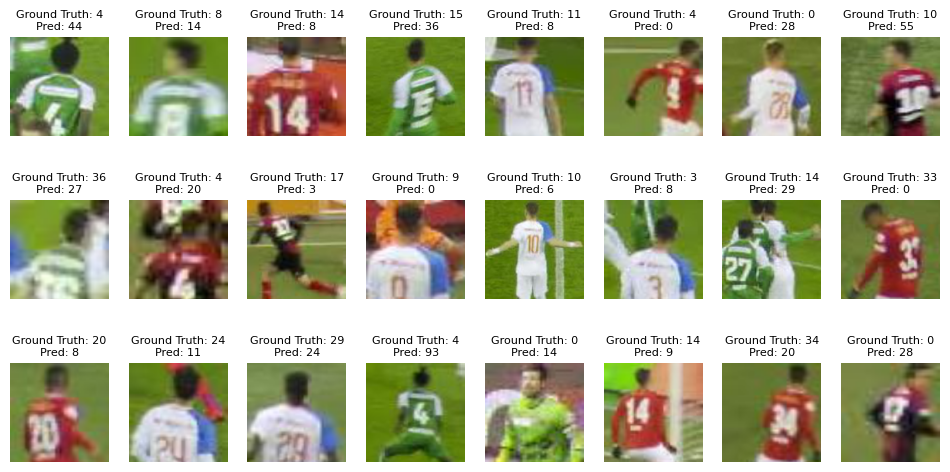

In [25]:
num_cols = 8
num_rows = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes to make it easier to index them
axes = axes.flatten()

for i in range(num_rows * num_cols):
    if i < len(images):  # so that we don't try to access more images than available in the batch
        ax = axes[i]
        image = wrong_images[i]
        # Convert from CxHxW to HxWxC for plotting
        image_np = image.permute(1, 2, 0).numpy()

        ax.imshow(image_np, cmap='gray')
        ax.set_title(f"Ground Truth: {wrong_labels[i]}\nPred: {wrong_predictions[i]}", fontsize=8)
        ax.axis('off')
    else:
        ax = axes[i]
        ax.axis('off')

plt.subplots_adjust()
plt.show()

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

In [27]:
# from new model -> weights from scratch
net2 = JerseyNumberClassifier()
net2.to(DEVICE)

JerseyNumberClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [49]:
def training_loop_tracking_loss(model, optimizer, criterion, epochs, train_loader, device, total_train_losses=[], total_train_acc=[] ):

    for epoch in range(epochs):

        total_loss_in_epoch = 0
        correct_preds = 0
        total_preds = 0

        # Training 
        for inputs, ground_truths in train_loader:

            inputs = inputs.to(device)
            ground_truths = ground_truths.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)    
            loss = criterion(outputs, ground_truths)     
            loss.backward()
            optimizer.step()

            total_loss_in_epoch += loss.item()       # accumulate loss for this batch
            correct_preds += (torch.argmax(outputs, dim=1) == ground_truths).sum().item()
            total_preds += outputs.size(0)

        # average out the loss and accuracy across the batch
        avg_train_loss = round(total_loss_in_epoch / inputs.size(0), 4)
        train_accuracy = round((correct_preds / total_preds) * 100, 4)

        total_train_losses.append(avg_train_loss)
        total_train_acc.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss} | Train Accuracy: {train_accuracy}% \nNumber of jersey numbers correctly predicted: {correct_preds}")
        print("=" * 20)

    return total_train_losses, total_train_acc


In [28]:
# Train the model and get loss values
epochs=10
training_loop(net2, optimizer, criterion, epochs, train_loader, DEVICE)

Epoch 1/10
Train Loss: 851.6966 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 2/10
Train Loss: 851.6975 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 3/10
Train Loss: 851.6975 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 4/10
Train Loss: 851.6958 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 5/10
Train Loss: 851.6975 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 6/10
Train Loss: 851.6981 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 7/10
Train Loss: 851.6976 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 8/10
Train Loss: 851.6967 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 9/10
Train Loss: 851.696 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 10/10
Train Loss: 851.6951 | Train Accuracy: 0.0% 
Number o

In [30]:
wrong_images = []
wrong_labels = []
wrong_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = net2(inputs)
        _, preds = torch.max(outputs, 1)

        # Check each image in the batch for misclassification
        for i in range(len(labels)):
            if preds[i] != labels[i].item():
                wrong_images.append(inputs[i].cpu())
                wrong_labels.append(labels[i].cpu().item())
                wrong_predictions.append(preds[i].cpu().item())

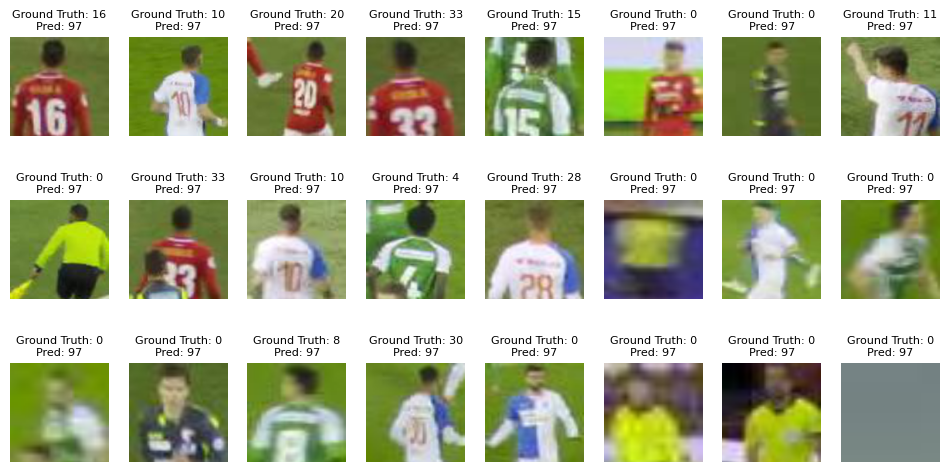

In [31]:
num_cols = 8
num_rows = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes to make it easier to index them
axes = axes.flatten()

for i in range(num_rows * num_cols):
    if i < len(images):  # so that we don't try to access more images than available in the batch
        ax = axes[i]
        image = wrong_images[i]
        # Convert from CxHxW to HxWxC for plotting
        image_np = image.permute(1, 2, 0).numpy()

        ax.imshow(image_np, cmap='gray')
        ax.set_title(f"Ground Truth: {wrong_labels[i]}\nPred: {wrong_predictions[i]}", fontsize=8)
        ax.axis('off')
    else:
        ax = axes[i]
        ax.axis('off')

plt.subplots_adjust()
plt.show()